In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai

In [3]:
from fastai.imports import *

In [ ]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai import dataset,dataloader

In [5]:
import json
import pandas as pd
from pathlib import Path
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
from sklearn.metrics import mean_absolute_error

In [6]:
import torch
from torch import nn
import torchvision.transforms as torch_tfms

In [20]:
print('numpy version: {}'.format(np.__version__))
from matplotlib import __version__ as mplver
print('matplotlib version: {}'.format(mplver))

numpy version: 1.15.4
matplotlib version: 3.0.2


In [21]:
pv = sys.version_info
print('python version: {}.{}.{}'.format(pv.major, pv.minor, pv.micro))

python version: 3.6.8


In [7]:
#Path to the folder with data
PATH = "/home/ilaria/Projects/deeplung_fastai/data/nodules_imgs/"
MIN_BOUND = -1000.0
MAX_BOUND = 400.0

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.backends.cudnn.enabled

True

In [9]:
os.listdir(PATH)

['tmp', 'train', 'test', 'valid', 'sample', 'models']

In [10]:
files = os.listdir(f'{PATH}/train/mal_1')[:3]

In [11]:
loc = f'{PATH}train/mal_1/{files[0]}'
print(loc)

/home/ilaria/Projects/deeplung_fastai/data/nodules_imgs/train/mal_1/1.3.6.1.4.1.14519.5.2.1.6279.6001.185154482385982570363528682299_nod0.npz


In [12]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i],cmap='gray',interpolation='nearest')

In [13]:
def clip_data(data, verbose=0):
    if verbose > 0:
        print("\nData before clip:", data.shape, np.max(data), np.min(data))

    # make image between 0 .. 1 corresponding to HU values -1000 to 400
    data[data < MIN_BOUND] = MIN_BOUND
    data[data > MAX_BOUND] = MAX_BOUND

    if verbose > 0:
        print("Data after clip:", data.shape, np.max(data), np.min(data))

    return data

def normalize_data(data, verbose=0):
    if verbose > 0:
        print("\nData before normalize:", data.shape, np.max(data), np.min(data))

    # make image between 0 .. 1 corresponding to HU values -1000 to 400
    data = (data - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)

    if verbose > 0:
        print("Data after normalize:", data.shape, np.max(data), np.min(data))

    return data

In [14]:
def open_cube_3_axial(loc):
    npz = np.load(loc)
    cube, targets, pos = npz['data'], npz["targets"], npz['positions']
    mid = cube.shape[0]//2
    cube = cube[mid-1:mid+2, :, :]
    cube = np.moveaxis(cube, 0, -1)

    #Normalize cubes (without it, data augmantation fails)
    cube = clip_data(cube)
    cube = normalize_data(cube)
    return cube  

In [15]:
def get_data(PATH_CUBES, tfms, bs):
    #data = ImageClassifierData.from_csv(PATH_CUBES, 'train', train_csv, tfms=tfms, bs=bs, test_name='test',
     #                                   suffix='.npy', skip_header=True, num_workers=1)
    data = ImageClassifierData.from_paths(PATH, tfms)
    x, _ = next(iter(data.trn_dl))
    print(x.shape)
    cb = data.trn_ds.denorm(x)[0]
    cb = np.moveaxis(cb, -1, 0)
    return cb


In [16]:
dataset.open_image = open_cube_3_axial

In [93]:
myimg = open_nodule_3_axial(loc)

In [94]:
myimg.shape

(32, 32, 32)

In [17]:
f_model = resnet34
resize = sz = 32
bs = 2
fms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [89]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 64, 16, 16]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 16, 16]),
                           ('output_shape', [-1, 64, 16, 16]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 16, 16]),
                           ('output_shape', [-1, 64, 16, 16]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 16, 16]),
                           ('output_shape', [-1, 64, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 8, 8]),
            

In [49]:
data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=fms)

In [19]:
dx = data.val_ds.denorm(x)[0]
print(dx.shape)
plt.figure(figsize=(15,6))
ax = plt.subplot(1,4,1)
plt.imshow(dx, cmap='gray');
ax = plt.subplot(1,4,2)
plt.imshow(dx[:,:,0], cmap='gray');
ax = plt.subplot(1,4,3)
plt.imshow(dx[:,:,1], cmap='gray');
ax = plt.subplot(1,4,4)
plt.imshow(dx[:,:,2], cmap='gray');
plt.show()

NameError: name 'x' is not defined

In [50]:
learn = ConvLearner.pretrained(f_model, data, precompute=True)

In [51]:
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy                 
    0      1.375245   1.967454   0.526316  
    1      1.702197   1.914158   0.631579                  



[array([1.91416]), 0.631578947368421]

In [52]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

In [53]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['mal_1', 'mal_4', 'mal_5']

In [54]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(19, 3)

In [55]:
log_preds

array([[ -0.75794,  -0.80388,  -2.47957],
       [ -0.00955,  -4.79648,  -6.68494],
       [-11.44795,  -9.85966,  -0.00006],
       [ -0.00311,  -8.80807,  -5.82509],
       [ -0.00124, -14.42174,  -6.69437],
       [ -0.00005, -10.02698, -11.98979],
       [ -0.04417,  -3.27384,  -5.23136],
       [ -0.61922,  -0.78571,  -5.14245],
       [ -0.00107,  -8.44831,  -7.06898],
       [ -0.01909,  -4.01269,  -7.1063 ],
       [ -7.2169 ,  -0.00426,  -5.65095],
       [ -8.61043,  -0.81066,  -0.58833],
       [-29.0558 ,  -0.00117,  -6.7508 ],
       [ -7.63388,  -0.00275,  -6.09082],
       [ -5.58786,  -0.00422,  -7.67299],
       [ -0.02175,  -4.04276,  -5.52994],
       [-16.26751,  -0.01958,  -3.94329],
       [-18.46727,  -0.00547,  -5.21043],
       [-20.20847,  -0.01914,  -3.96531]], dtype=float32)

In [26]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(mal_1)

In [27]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [28]:
rand_by_correct(True)

array([11, 12,  9,  6])

In [29]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [30]:
def load_img_id(ds, idx): return np.array(open_cube_3_axial(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Correctly classified


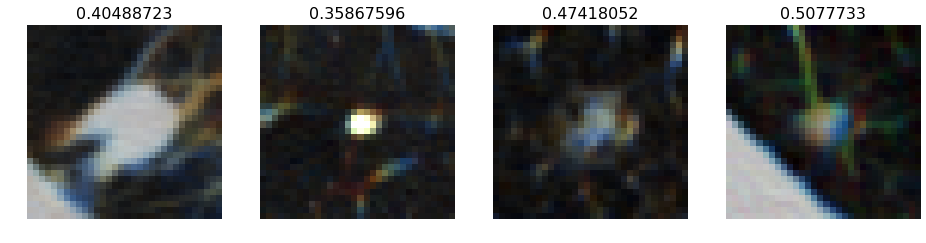

In [31]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


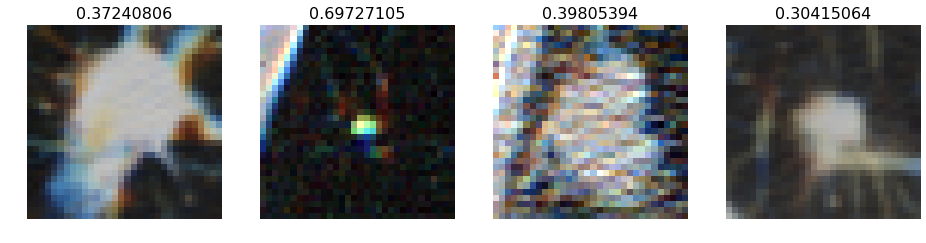

In [32]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [33]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct nodules mal_0


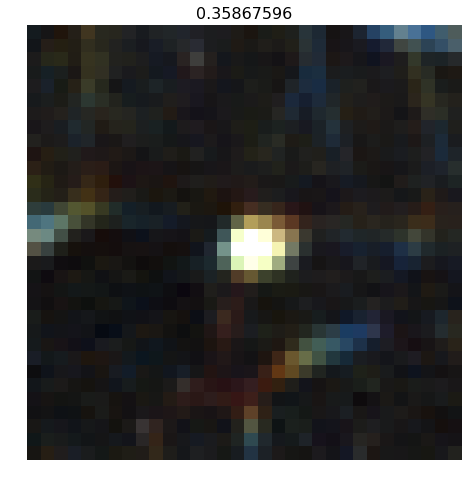

In [34]:
plot_val_with_title(most_by_correct(0, True), "Most correct nodules mal_0")

Most correct nodules mal_4


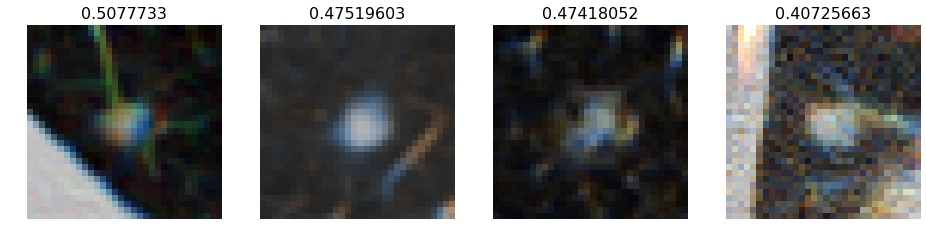

In [35]:
plot_val_with_title(most_by_correct(1, True), "Most correct nodules mal_4")

Most incorrect nodules mal_5


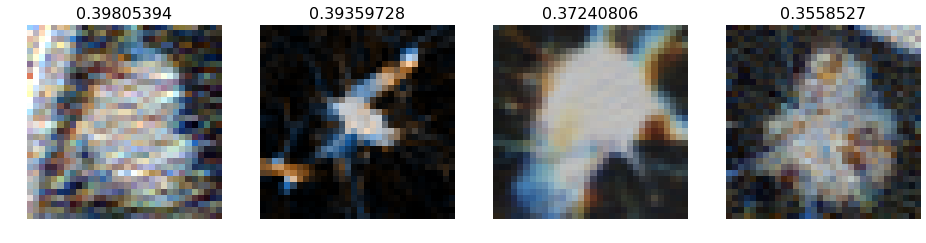

In [36]:
## plot_val_with_title(most_by_correct(0, False), "Most incorrect nodules mal_5")

plot_val_with_title(most_by_correct(2, False), "Most incorrect nodules mal_5")

Most uncertain predictions


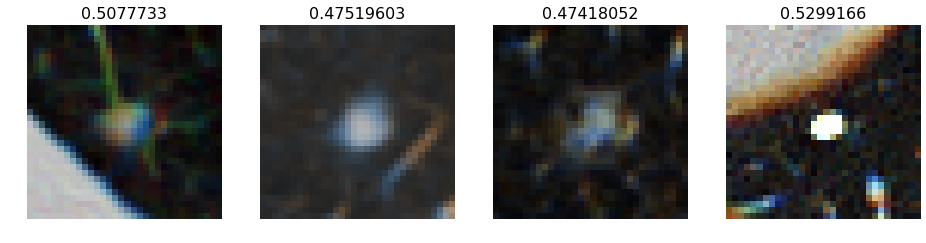

In [37]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [56]:
learn = ConvLearner.pretrained(f_model, data, precompute=True)

In [57]:
lrf = learn.lr_find()

 74%|███████▎  | 14/19 [00:00<00:00, 42.42it/s, loss=1.25]


In [58]:
lrf=learn.lr_find()

 53%|█████▎    | 10/19 [00:00<00:00, 42.10it/s, loss=1.39]


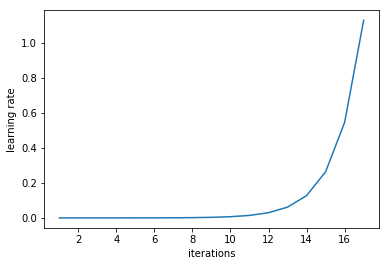

In [59]:
learn.sched.plot_lr()

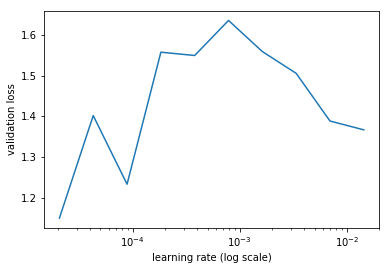

In [64]:
learn.sched.plot(1)

In [65]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [66]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [67]:
ims = np.stack([get_augs() for i in range(6)])

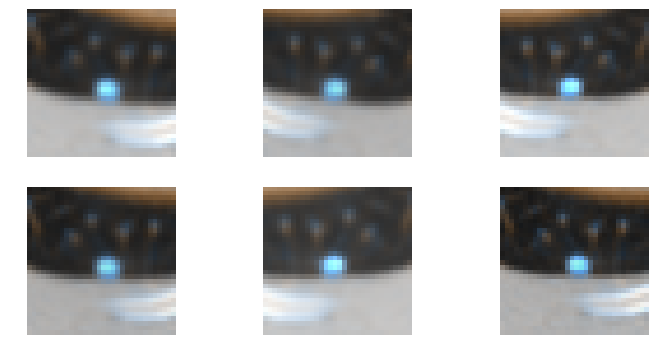

In [68]:
plots(ims, rows=2)

Let's create a new data object that includes this augmentation in the transforms.

In [69]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(f_model, data, precompute=True)

In [70]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy        
    0      1.438697   1.177215   0.315789  



[array([1.17722]), 0.31578946113586426]

In [71]:
learn.precompute=False

In [75]:
learn.fit(1e-1, 3, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                
    0      0.648317   1.099048   0.473684  
    1      0.741842   0.992204   0.684211                
    2      0.636516   0.891608   0.631579                
    3      0.544293   0.875885   0.631579                
    4      0.499158   0.92373    0.631579                
    5      0.436302   0.97431    0.578947                



[array([0.97431]), 0.5789473652839661]

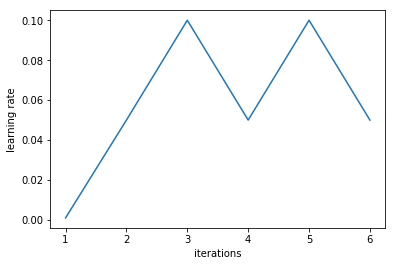

In [76]:
learn.sched.plot_lr()

In [77]:
learn.save('32_lastlayer')

In [80]:
learn.load('32_lastlayer')

### Fine-tuning and differential learning rate annealing
Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) unfreeze().


In [81]:
learn.unfreeze()

In [82]:
lr=np.array([1e-4,1e-3,1e-2])

In [83]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                
    0      0.87795    1.033798   0.578947  
    1      1.058177   1.079451   0.631579                
    2      1.074593   1.087744   0.421053                
    3      0.994149   1.103449   0.473684                
    4      0.919631   1.188943   0.421053                
    5      0.838659   1.242948   0.421053                
    6      0.79709    1.31401    0.315789                



[array([1.31401]), 0.31578946113586426]

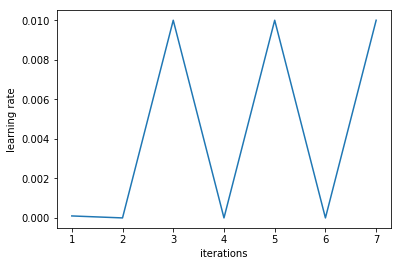

In [84]:
learn.sched.plot_lr()

In [85]:
learn.save('32_all')
learn.load('32_all')

In [87]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [88]:
accuracy_np(probs, y)

0.47368421052631576

In [89]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [90]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)


[[5 2 2]
 [3 3 0]
 [1 2 1]]


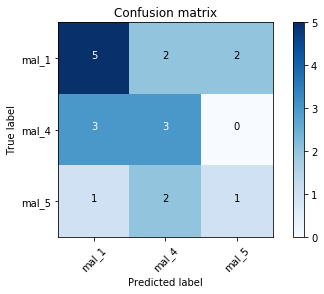

In [91]:
plot_confusion_matrix(cm, data.classes)